In [1]:
import os
import math
from pathlib import Path
import IPython
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import RandomOverSampler
from SSL import select_query,play_audio,generate_evaluation_dictionary,run_grid_search_cv,run

In [2]:
# functionals_df: raw data of eGeMAPS functionals
# functionals_h: human labeled data's eGeMAPS functionals
# human_labeled: human labeled data
# raw_data: raw data
functionals_df=pd.read_csv('/unix/cdtdisspotify/haoyueyu/podcast-dataset/data/functionals_df.csv')
functionals_h=pd.read_csv('/unix/cdtdisspotify/haoyueyu/podcast-dataset/data/functionals_h.csv')
human_labeled=pd.read_csv('/unix/cdtdisspotify/haoyueyu/podcast-dataset/data/labeled.csv')
raw_data=pd.read_csv(bm25_uri,sep='\t',header=None)

In [4]:
# Drop useless columns
human_labeled.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)
functionals_h.drop(['Unnamed: 0'],axis=1,inplace=True)

In [5]:
RANDOM_SEED=0
def generate_evaluation_dictionary(y,y_pred,y_score):
    # generate evalution dictionary
    output_dict=dict()
    output_dict['accuracy']=metrics.accuracy_score(y,y_pred)
    output_dict['roc_auc']=metrics.roc_auc_score(y,y_score[:,1])
    output_dict['f1']=metrics.f1_score(y,y_pred)
    output_dict['precision']=metrics.precision_score(y,y_pred,average='weighted')
    output_dict['recall']=metrics.recall_score(y,y_pred)
    return output_dict


def run_grid_search_cv( X_train,y_train,model,param_grid):
    # run grid search cross validation
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    grid = GridSearchCV(model, param_grid=param_grid, cv=cv)
    grid.fit(X_train,y_train)
    clf=grid.best_estimator_
    return clf

# Entertaining

## Labelling

In [6]:
functionals_df['label']=2
functionals_h['label']=-1
for i,r in functionals_h.iterrows():
    if 'funny' in human_labeled.entertaining[i]:
        functionals_h.loc[i,'label']=1
 
df_all = pd.concat([functionals_df,functionals_h],axis=0, ignore_index=True)
standard_transform = StandardScaler().fit(df_all.iloc[:,:88])
df_std=df_all.copy()
df_std.iloc[:,:88]=standard_transform.transform(df_all.iloc[:,:88])

In [7]:
labeled_data=df_std.iloc[-200:,:]
labeled_data['label'].value_counts()

 1    103
-1     97
Name: label, dtype: int64

## Feature Selection

In [8]:
clf = ExtraTreesClassifier(n_estimators=50,random_state=RANDOM_SEED)
clf = clf.fit(labeled_data.iloc[:,:88], labeled_data.label)
model = SelectFromModel(clf, prefit=True)
opensmile_important_features=df_std.columns[:88][model.get_support()]
print('Number of features selected %d' %len(opensmile_important_features)) 

Number of features selected 37


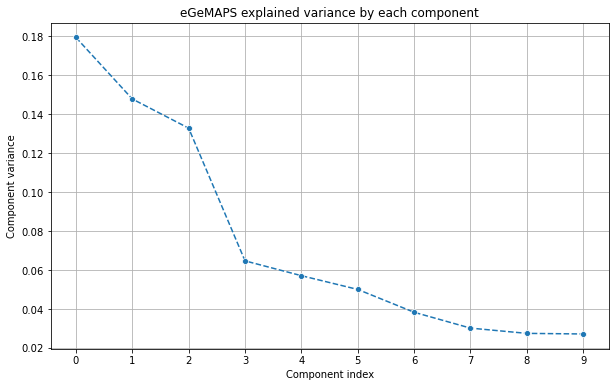

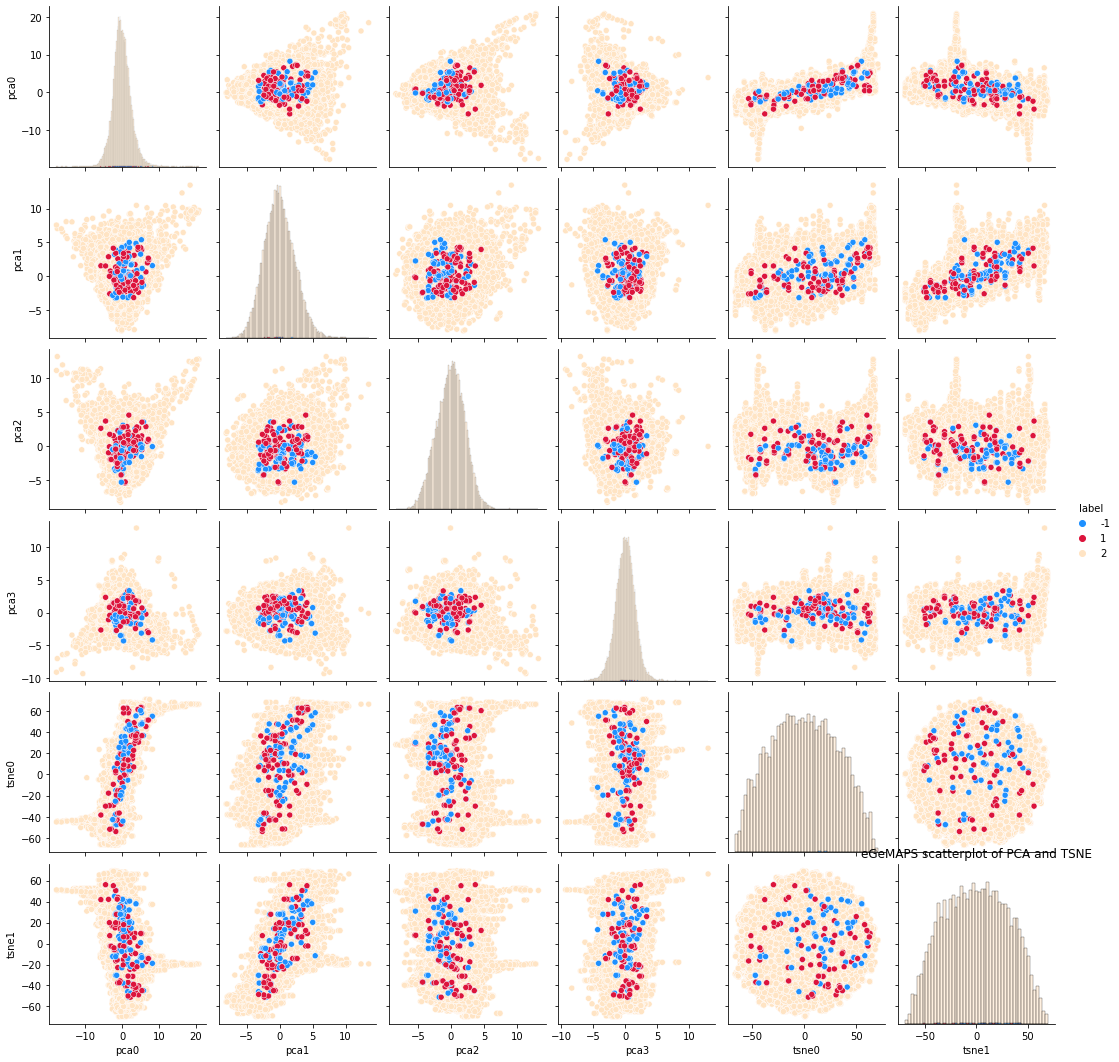

In [9]:
standardised_input = df_std[opensmile_important_features]
pca= PCA(n_components=10, random_state=RANDOM_SEED)
pca_result = pca.fit_transform(standardised_input)
plt.figure(figsize=(10,6))
sns.lineplot(x=np.arange(10),y=pca.explained_variance_ratio_,marker='o',linestyle='--')
plt.grid()
plt.xlabel('Component index')
plt.xticks(np.arange(0, 10, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Component variance')
plt.title('eGeMAPS explained variance by each component')
plt.savefig("pca_opensmile_e.png")
pca_result_split = np.split(pca_result, 10, axis=1)
for component in range(4):
        df_std["pca" + str(component)] = pca_result_split[component]

        
tsne = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, random_state=1)
tsne_result = tsne.fit_transform(standardised_input)
tsne_result_split = np.split(tsne_result, 2, axis=1)
for component in range(2):
        df_std["tsne" + str(component)] = tsne_result_split[component]
sns.pairplot(df_std,vars=["pca0","pca1","pca2","pca3",'tsne0','tsne1'],palette=['dodgerblue','crimson','bisque'],hue='label',kind="scatter",diag_kind="hist")
plt.title('eGeMAPS scatterplot of PCA and TSNE')
plt.savefig("PCATSNE_opensmile.png")


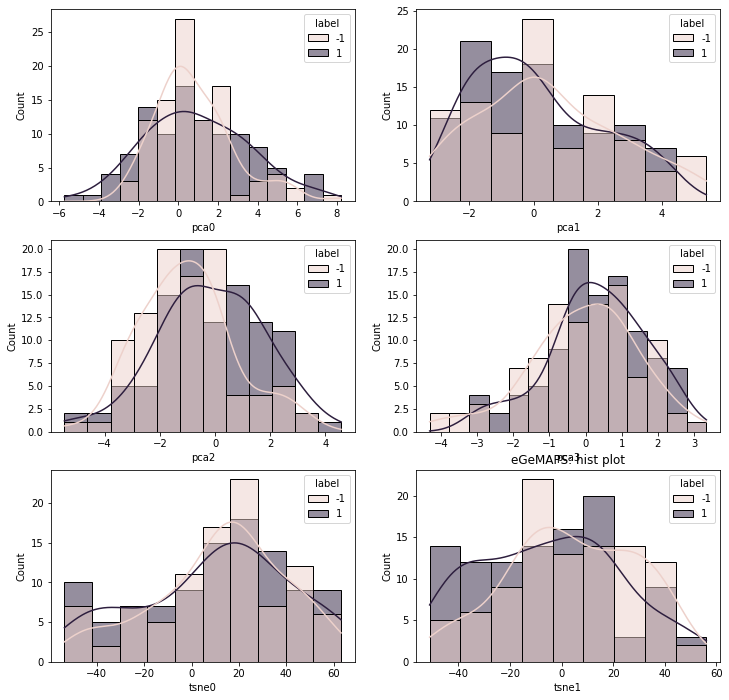

In [10]:
fig, ax_arr = plt.subplots(3,2, figsize=(12,12))

sns.histplot(df_std.iloc[-200:,:],x='pca0',hue='label',kde=True,ax = ax_arr[0][0])
sns.histplot(df_std.iloc[-200:,:],x='pca1',hue='label',kde=True,ax = ax_arr[0][1])
sns.histplot(df_std.iloc[-200:,:],x='pca2',hue='label',kde=True,ax = ax_arr[1][0])
sns.histplot(df_std.iloc[-200:,:],x='pca3',hue='label',kde=True,ax = ax_arr[1][1])
sns.histplot(df_std.iloc[-200:,:],x='tsne0',hue='label',kde=True,ax = ax_arr[2][0])
sns.histplot(df_std.iloc[-200:,:],x='tsne1',hue='label',kde=True,ax = ax_arr[2][1])
plt.title('eGeMAPS: hist plot')
plt.savefig("hist_opensmile.png")


## PCA and TSNE

In [11]:
# Standardise features
df_PCA_TSNE=df_std.iloc[:,-7:]
df_PCA_TSNE.iloc[:,1:]=StandardScaler().fit_transform(df_PCA_TSNE.iloc[:,1:])
#Divide manually labelled data and unlabelled data
labeled_data=df_PCA_TSNE.iloc[-200:,:]
unlabeled_data=df_PCA_TSNE.iloc[:-200, 1:]
#Set random seed
np.random.seed(RANDOM_SEED)
training_indices = list(labeled_data.index[0]+np.random.permutation(199))[:120]
X_train=labeled_data.loc[training_indices,:].iloc[:,-6:]
y_train=labeled_data.label[training_indices]
test_data=labeled_data.loc[[ind for ind in labeled_data.index if ind not in training_indices],:]

In [12]:
baseline_dic=dict()

### Baseline SVC rbf

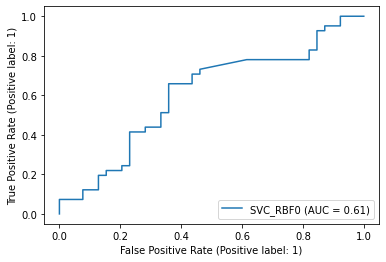

In [13]:
#Initialise the model and tune the parameters 
model=SVC(kernel='rbf',probability=True)
C_range = np.logspace(1, 5, 6)
gamma_range = np.logspace(-7, 1, 9)
param_grid =dict(gamma=gamma_range, C=C_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic['SVC_rbf']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_rbf0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_RBF0')  

### Baseline SVC poly

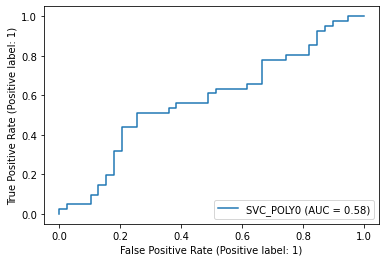

In [14]:
#Initialise the model and tune the parameters 
model=SVC(kernel='poly',probability=True)
coef0_range = np.arange(1,10,2)
gamma_range = np.logspace(-5, 1, 7)
param_grid =dict(gamma=gamma_range, coef0=coef0_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,-6:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['SVC_poly']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_poly0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_POLY0')  

### Baseline Random Forest

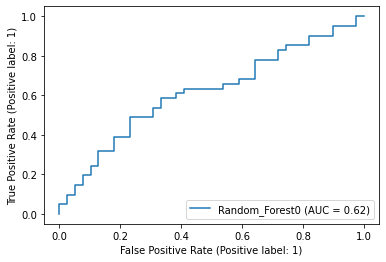

In [15]:
#Initialise the model and tune the parameters 
model=RandomForestClassifier(random_state=RANDOM_SEED)
n_estimators_range = np.arange(50,60,5)
criterion_range = ['gini','entropy']
min_samples_leaf_range=np.arange(2,20,4) 
param_grid=dict(n_estimators=n_estimators_range, criterion=criterion_range,min_samples_leaf=min_samples_leaf_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,-6:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['random_forest']=pd.DataFrame(evaluation_dic,index=[0])
rf_disp0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Random_Forest0')  

### Baseline NaiveBayes

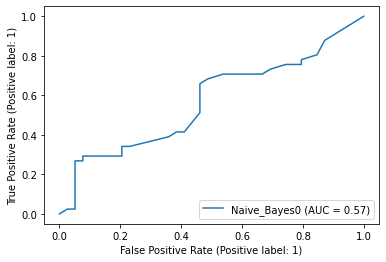

In [16]:
#Initialise the model and tune the parameters 
model = BernoulliNB()
clf=BernoulliNB().fit(X_train,y_train)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['Naive_bayes']=pd.DataFrame(evaluation_dic,index=[0])
nb_disp_poly0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Naive_Bayes0')  

### Generate evaluation table

In [17]:
baseline_df=pd.DataFrame(index=baseline_dic['SVC_rbf'].keys(),columns=baseline_dic.keys())
for i in baseline_df.columns:
    for j in baseline_dic[i]:
        baseline_df.loc[j,i]
        baseline_dic[i]
        baseline_df.loc[j,i]=baseline_dic[i][j][0]
baseline_df=baseline_df.T
baseline_df

,accuracy,roc_auc,f1,precision,recall
SVC_rbf,0.6125,0.607255,0.635294,0.612405,0.658537
SVC_poly,0.5375,0.577861,0.554217,0.537234,0.560976
random_forest,0.6,0.617261,0.6,0.60075,0.585366
Naive_bayes,0.5625,0.56723,0.578313,0.562265,0.585366


## Raw reduced features

In [18]:
# Standardise features
df_raw_reduced=df_std[opensmile_important_features]
df_raw_reduced.insert(0,'label', df_std.label)
#Divide manually labelled data and unlabelled data
labeled_data=df_raw_reduced.iloc[-200:,:]
unlabeled_data=df_raw_reduced.iloc[:-200, 1:]
#Set random seed
np.random.seed(RANDOM_SEED)
training_indices = list(labeled_data.index[0]+np.random.permutation(199))[:120]
X_train=labeled_data.loc[training_indices,:].iloc[:,1:]
y_train=labeled_data.label[training_indices]
test_data=labeled_data.loc[[ind for ind in labeled_data.index if ind not in training_indices],:]

In [19]:
baseline_dic=dict()

### Baseline SVC rbf

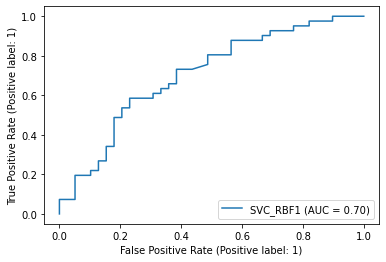

In [20]:
#Initialise the model and tune the parameters 
model=SVC(kernel='rbf',probability=True)
C_range = np.logspace(-2, 4, 7)
gamma_range = np.logspace(-7, 1, 9)
param_grid =dict(gamma=gamma_range, C=C_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic['SVC_rbf']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_rbf1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_RBF1')  

### Baseline SVC poly

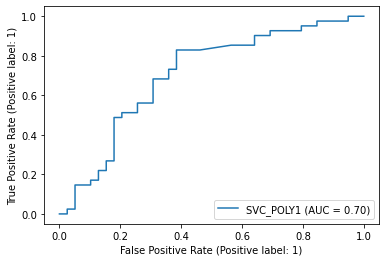

In [21]:
#Initialise the model and tune the parameters 
model=SVC(kernel='poly',probability=True)
coef0_range = np.arange(-15,25,5)
gamma_range = np.logspace(-5, 2, 7)
param_grid =dict(gamma=gamma_range, coef0=coef0_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['SVC_poly']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_poly1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_POLY1')  

### Baseline Random Forest

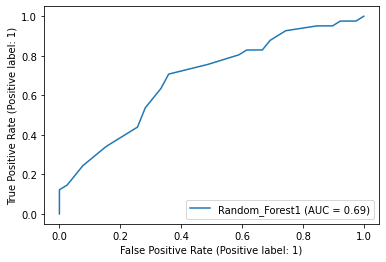

In [22]:
#Initialise the model and tune the parameters 
model=RandomForestClassifier(random_state=RANDOM_SEED)
n_estimators_range = np.arange(10,30,5)
criterion_range = ['gini','entropy']
min_samples_leaf_range=np.arange(1,10,2) 
param_grid=dict(n_estimators=n_estimators_range, criterion=criterion_range,min_samples_leaf=min_samples_leaf_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['random_forest']=pd.DataFrame(evaluation_dic,index=[0])
rf_disp1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Random_Forest1')  

### Baseline NaiveBayes

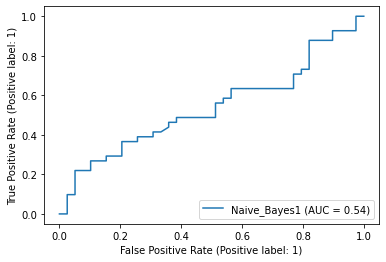

In [23]:
#Initialise the model and tune the parameters 
model = BernoulliNB()
clf=BernoulliNB().fit(X_train,y_train)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['Naive_bayes']=pd.DataFrame(evaluation_dic,index=[0])
clf
nb_disp_poly1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Naive_Bayes1')  

### Generate evaluation table

In [24]:
baseline_df=pd.DataFrame(index=baseline_dic['SVC_rbf'].keys(),columns=baseline_dic.keys())
for i in baseline_df.columns:
    for j in baseline_dic[i]:
        baseline_df.loc[j,i]
        baseline_dic[i]
        baseline_df.loc[j,i]=baseline_dic[i][j][0]
baseline_df=baseline_df.T
baseline_df

,accuracy,roc_auc,f1,precision,recall
SVC_rbf,0.6625,0.703565,0.682353,0.662784,0.707317
SVC_poly,0.6875,0.703565,0.712644,0.689498,0.756098
random_forest,0.6375,0.686366,0.681319,0.64275,0.756098
Naive_bayes,0.5125,0.538149,0.551724,0.511141,0.585366


## Plot ROC

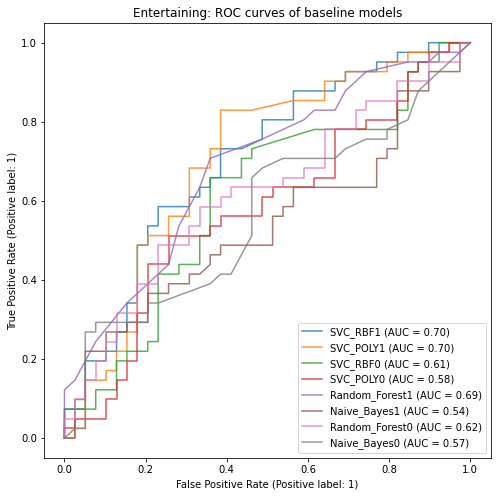

In [25]:
plt.figure(figsize=(8,8))
ax=plt.gca()
svc_disp_rbf1.plot(ax=ax,alpha=0.8)
svc_disp_poly1.plot(ax=ax,alpha=0.8)
svc_disp_rbf0.plot(ax=ax,alpha=0.8)
svc_disp_poly0.plot(ax=ax,alpha=0.8)

rf_disp1.plot(ax=ax,alpha=0.8)
nb_disp_poly1.plot(ax=ax,alpha=0.8)
rf_disp0.plot(ax=ax,alpha=0.8)
nb_disp_poly0.plot(ax=ax,alpha=0.8)

plt.title('Entertaining: ROC curves of baseline models')
plt.savefig('ROC_all_e')

# Subjective

## Labelling

In [26]:
functionals_df['label']=2
functionals_h['label']=-1
for i,r in functionals_h.iterrows():
    if 'pproval' in human_labeled.subjective[i] :
        functionals_h.loc[i,'label']=1
df_all = pd.concat([functionals_df,functionals_h],axis=0, ignore_index=True)
standard_transform = StandardScaler().fit(df_all.iloc[:,:88])
df_std=df_all.copy()
df_std.iloc[:,:88]=standard_transform.transform(df_all.iloc[:,:88])

In [27]:
labeled_data=df_std.iloc[-200:,:]
labeled_data.label.value_counts()

-1    106
 1     94
Name: label, dtype: int64

## Feature Selection

In [28]:
clf = ExtraTreesClassifier(n_estimators=50,random_state=RANDOM_SEED)
clf = clf.fit(labeled_data.iloc[:,:88], labeled_data.label)
model = SelectFromModel(clf, prefit=True)
opensmile_important_features=df_std.columns[:88][model.get_support()]
print('Number of features selected %d' %len(opensmile_important_features)) 

Number of features selected 40


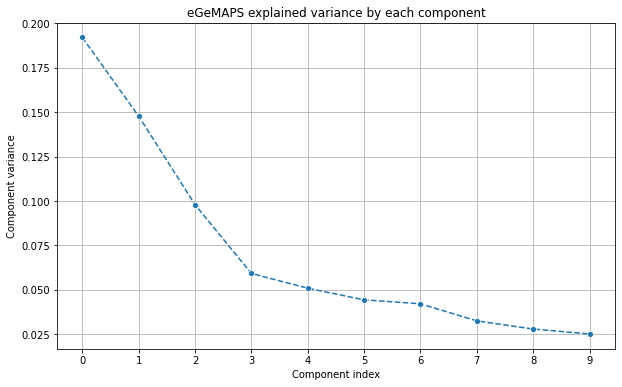

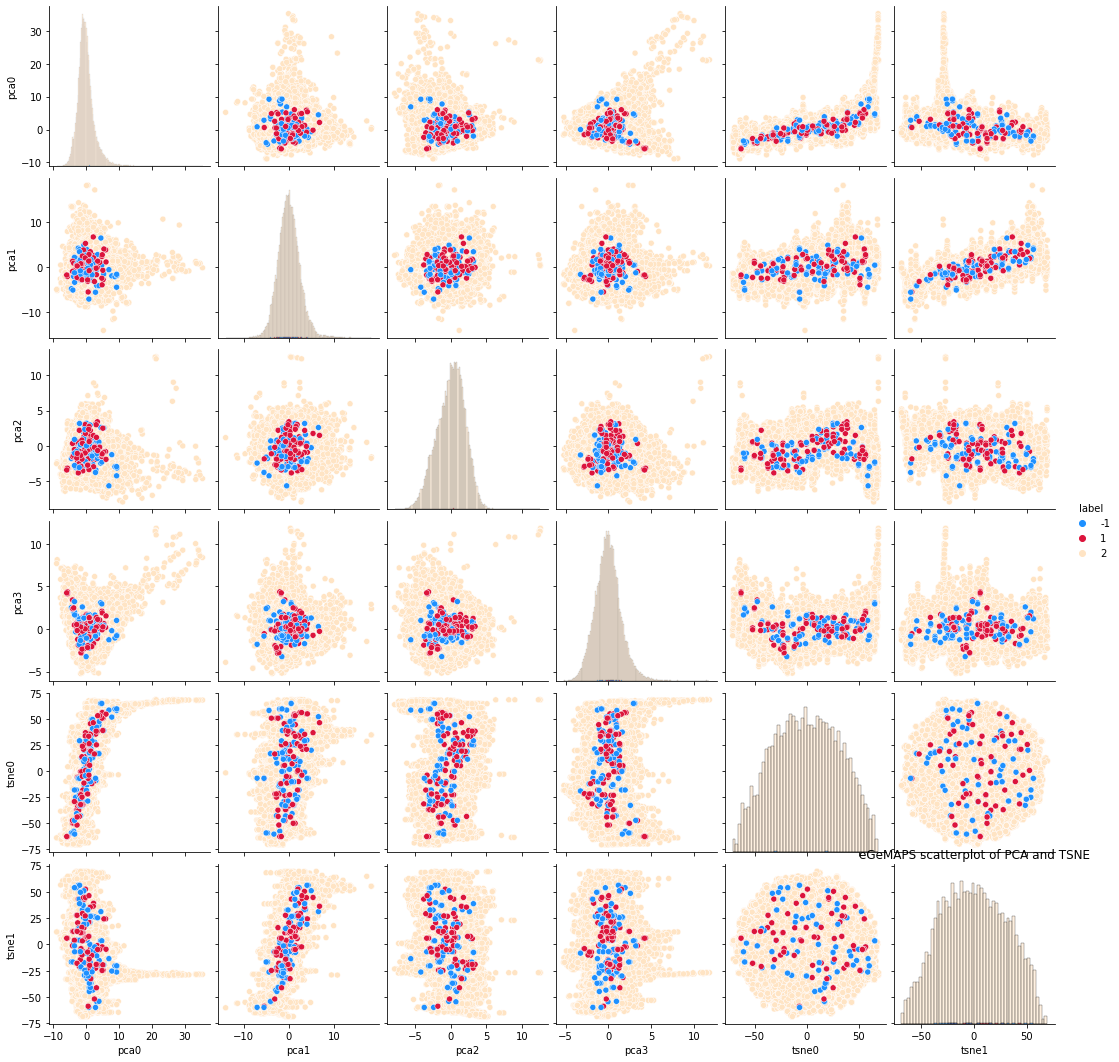

In [29]:
standardised_input = df_std[opensmile_important_features]
pca= PCA(n_components=10, random_state=RANDOM_SEED)
pca_result = pca.fit_transform(standardised_input)
plt.figure(figsize=(10,6))
sns.lineplot(x=np.arange(10),y=pca.explained_variance_ratio_,marker='o',linestyle='--')
plt.grid()
plt.xlabel('Component index')
plt.xticks(np.arange(0, 10, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Component variance')
plt.title('eGeMAPS explained variance by each component')
plt.savefig("pca_opensmile_s.png")
pca_result_split = np.split(pca_result, 10, axis=1)
for component in range(4):
        df_std["pca" + str(component)] = pca_result_split[component]

        
tsne = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, random_state=1)
tsne_result = tsne.fit_transform(standardised_input)
tsne_result_split = np.split(tsne_result, 2, axis=1)
for component in range(2):
        df_std["tsne" + str(component)] = tsne_result_split[component]
sns.pairplot(df_std,vars=["pca0","pca1","pca2","pca3",'tsne0','tsne1'],palette=['dodgerblue','crimson','bisque'],hue='label',kind="scatter",diag_kind="hist")
plt.title('eGeMAPS scatterplot of PCA and TSNE')
plt.savefig("PCATSNE_opensmile.png")


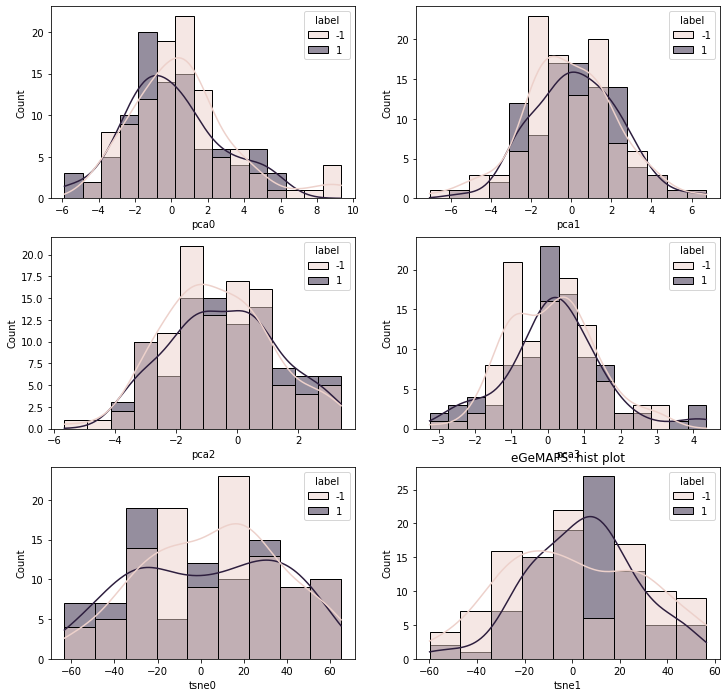

In [30]:
fig, ax_arr = plt.subplots(3,2, figsize=(12,12))

sns.histplot(df_std.iloc[-200:,:],x='pca0',hue='label',kde=True,ax = ax_arr[0][0])
sns.histplot(df_std.iloc[-200:,:],x='pca1',hue='label',kde=True,ax = ax_arr[0][1])
sns.histplot(df_std.iloc[-200:,:],x='pca2',hue='label',kde=True,ax = ax_arr[1][0])
sns.histplot(df_std.iloc[-200:,:],x='pca3',hue='label',kde=True,ax = ax_arr[1][1])
sns.histplot(df_std.iloc[-200:,:],x='tsne0',hue='label',kde=True,ax = ax_arr[2][0])
sns.histplot(df_std.iloc[-200:,:],x='tsne1',hue='label',kde=True,ax = ax_arr[2][1])
plt.title('eGeMAPS: hist plot')
plt.savefig("hist_opensmile.png")


## PCA and TSNE

In [31]:
# Standardise features
df_PCA_TSNE=df_std.iloc[:,-7:]
df_PCA_TSNE.iloc[:,1:]=StandardScaler().fit_transform(df_PCA_TSNE.iloc[:,1:])
#Divide manually labelled data and unlabelled data
labeled_data=df_PCA_TSNE.iloc[-200:,:]
unlabeled_data=df_PCA_TSNE.iloc[:-200, 1:]
#Set random seed
np.random.seed(RANDOM_SEED)
training_indices = list(labeled_data.index[0]+np.random.permutation(199))[:120]
X_train=labeled_data.loc[training_indices,:].iloc[:,-6:]
y_train=labeled_data.label[training_indices]
test_data=labeled_data.loc[[ind for ind in labeled_data.index if ind not in training_indices],:]

In [32]:
baseline_dic=dict()

### Baseline SVC rbf

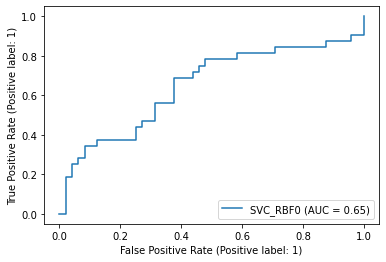

In [33]:
#Initialise the model and tune the parameters 
model=SVC(kernel='rbf',probability=True)
C_range = np.logspace(-1, 5, 6)
gamma_range = np.logspace(-7, 1, 9)
param_grid =dict(gamma=gamma_range, C=C_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,-6:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic['SVC_rbf']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_rbf0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_RBF0')  

### Baseline SVC poly

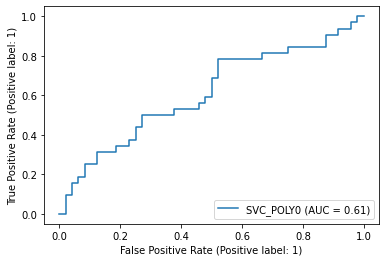

In [34]:
#Initialise the model and tune the parameters 
model=SVC(kernel='poly',probability=True)
coef0_range = np.arange(-15,25,5)
gamma_range = np.logspace(-5, 1, 7)
param_grid =dict(gamma=gamma_range, coef0=coef0_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,-6:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['SVC_poly']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_poly0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_POLY0')  

### Baseline Random Forest

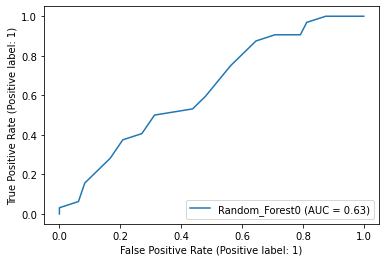

In [35]:
#Initialise the model and tune the parameters 
model=RandomForestClassifier(random_state=RANDOM_SEED)
n_estimators_range = np.arange(10,30,5)
criterion_range = ['gini','entropy']
min_samples_leaf_range=np.arange(1,20,4) 
param_grid=dict(n_estimators=n_estimators_range, criterion=criterion_range,min_samples_leaf=min_samples_leaf_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,-6:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['random_forest']=pd.DataFrame(evaluation_dic,index=[0])
rf_disp0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Random_Forest0')  

### Baseline NaiveBayes

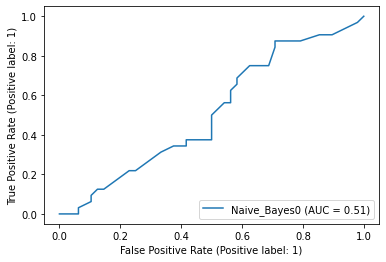

In [36]:
#Initialise the model and tune the parameters 
model = BernoulliNB()
alpha_range=np.arange(2,25,5)
param_grid=dict(alpha=alpha_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,-6:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['Naive_bayes']=pd.DataFrame(evaluation_dic,index=[0])
nb_disp_poly0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Naive_Bayes0')  

### Generate evaluation table

In [37]:
baseline_df=pd.DataFrame(index=baseline_dic['SVC_rbf'].keys(),columns=baseline_dic.keys())
for i in baseline_df.columns:
    for j in baseline_dic[i]:
        baseline_df.loc[j,i]
        baseline_dic[i]
        baseline_df.loc[j,i]=baseline_dic[i][j][0]
baseline_df=baseline_df.T
baseline_df

,accuracy,roc_auc,f1,precision,recall
SVC_rbf,0.5625,0.647786,0.597701,0.645091,0.8125
SVC_poly,0.5875,0.610026,0.60241,0.651251,0.78125
random_forest,0.55,0.629232,0.513514,0.575689,0.59375
Naive_bayes,0.5125,0.512695,0.506329,0.552031,0.625


## Raw reduced features

In [38]:
# Standardise features
df_raw_reduced=df_std[opensmile_important_features]
df_raw_reduced.insert(0,'label', df_std.label)
#Divide manually labelled data and unlabelled data
labeled_data=df_raw_reduced.iloc[-200:,:]
unlabeled_data=df_raw_reduced.iloc[:-200, 1:]
#Set random seed
np.random.seed(RANDOM_SEED)
training_indices = list(labeled_data.index[0]+np.random.permutation(199))[:120]
X_train=labeled_data.loc[training_indices,:].iloc[:,1:]
y_train=labeled_data.label[training_indices]
test_data=labeled_data.loc[[ind for ind in labeled_data.index if ind not in training_indices],:]

In [39]:
baseline_dic=dict()

### Baseline SVC rbf

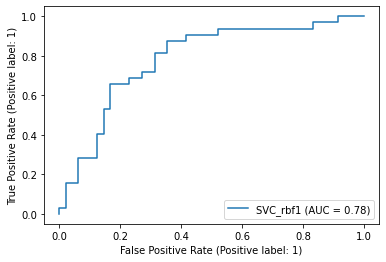

In [40]:
#Initialise the model and tune the parameters 
model=SVC(kernel='rbf',probability=True)
C_range = np.logspace(-1, 5, 6)
gamma_range = np.logspace(-7, 1, 9)
param_grid =dict(gamma=gamma_range, C=C_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic['SVC_rbf']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_rbf1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_rbf1')  

### Baseline SVC poly

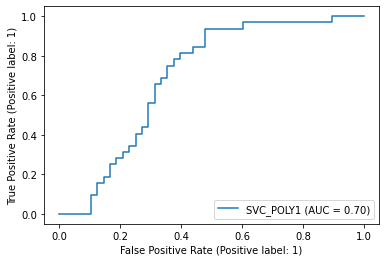

In [41]:
#Initialise the model and tune the parameters 
model=SVC(kernel='poly',probability=True)
coef0_range = np.arange(-15,25,5)
gamma_range = np.logspace(-5, 1, 7)
param_grid =dict(gamma=gamma_range, coef0=coef0_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['SVC_poly']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_poly1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_POLY1')  

### Baseline Random Forest

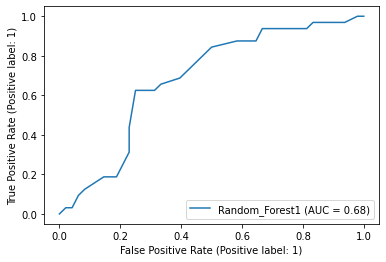

In [42]:
#Initialise the model and tune the parameters 
model=RandomForestClassifier(random_state=RANDOM_SEED)
n_estimators_range = np.arange(1,30,5)
criterion_range = ['gini','entropy']
min_samples_leaf_range=np.arange(1,20,4) 
param_grid=dict(n_estimators=n_estimators_range, criterion=criterion_range,min_samples_leaf=min_samples_leaf_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['random_forest']=pd.DataFrame(evaluation_dic,index=[0])
rf_disp1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Random_Forest1')  

### Baseline NaiveBayes

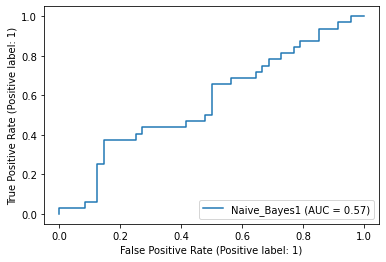

In [43]:
#Initialise the model and tune the parameters 
model = BernoulliNB()
alpha_range=np.arange(2,25,5)
param_grid=dict(alpha=alpha_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['Naive_bayes']=pd.DataFrame(evaluation_dic,index=[0])
nb_disp_poly1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Naive_Bayes1')  

### Generate evaluation table

In [44]:
baseline_df=pd.DataFrame(index=baseline_dic['SVC_rbf'].keys(),columns=baseline_dic.keys())
for i in baseline_df.columns:
    for j in baseline_dic[i]:
        baseline_df.loc[j,i]
        baseline_dic[i]
        baseline_df.loc[j,i]=baseline_dic[i][j][0]
baseline_df=baseline_df.T
baseline_df

,accuracy,roc_auc,f1,precision,recall
SVC_rbf,0.7,0.783854,0.707317,0.772,0.90625
SVC_poly,0.65,0.695964,0.658537,0.716,0.84375
random_forest,0.6375,0.682292,0.60274,0.660788,0.6875
Naive_bayes,0.55,0.569661,0.538462,0.588491,0.65625


## Plot ROC

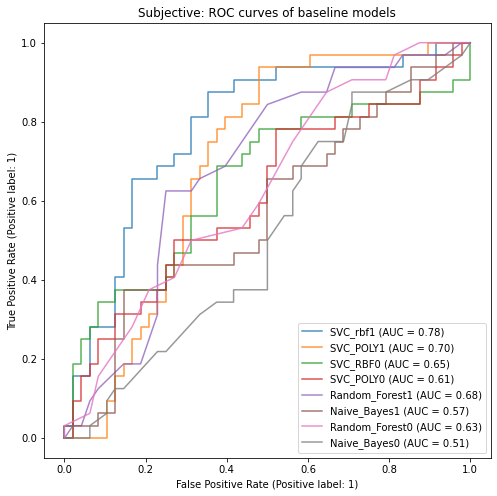

In [45]:
plt.figure(figsize=(8,8))
ax=plt.gca()
svc_disp_rbf1.plot(ax=ax,alpha=0.8)
svc_disp_poly1.plot(ax=ax,alpha=0.8)
svc_disp_rbf0.plot(ax=ax,alpha=0.8)
svc_disp_poly0.plot(ax=ax,alpha=0.8)

rf_disp1.plot(ax=ax,alpha=0.8)
nb_disp_poly1.plot(ax=ax,alpha=0.8)
rf_disp0.plot(ax=ax,alpha=0.8)
nb_disp_poly0.plot(ax=ax,alpha=0.8)

plt.title('Subjective: ROC curves of baseline models')
plt.savefig('ROC_all_s')

# Discussion

## Labelling

In [46]:
functionals_df['label']=2
functionals_h['label']=-1
for i,r in functionals_h.iterrows():
    if 'debate' in human_labeled.discussion[i] or  'conversation' in human_labeled.discussion[i]:
        functionals_h.loc[i,'label']=1
 
df_all = pd.concat([functionals_df,functionals_h],axis=0, ignore_index=True)
standard_transform = StandardScaler().fit(df_all.iloc[:,:88])
df_std=df_all.copy()
df_std.iloc[:,:88]=standard_transform.transform(df_all.iloc[:,:88])

In [47]:
labeled_data=df_std.iloc[-200:,:]
labeled_data.label.value_counts()

 1    154
-1     46
Name: label, dtype: int64

## Feature Selection

In [48]:
clf = ExtraTreesClassifier(n_estimators=50,random_state=RANDOM_SEED)
clf = clf.fit(labeled_data.iloc[:,:88], labeled_data.label)
model = SelectFromModel(clf, prefit=True)
opensmile_important_features=df_std.columns[:88][model.get_support()]
print('Number of features selected %d' %len(opensmile_important_features)) 

Number of features selected 35


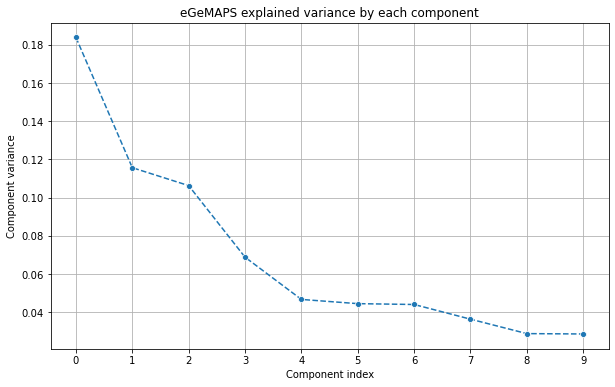

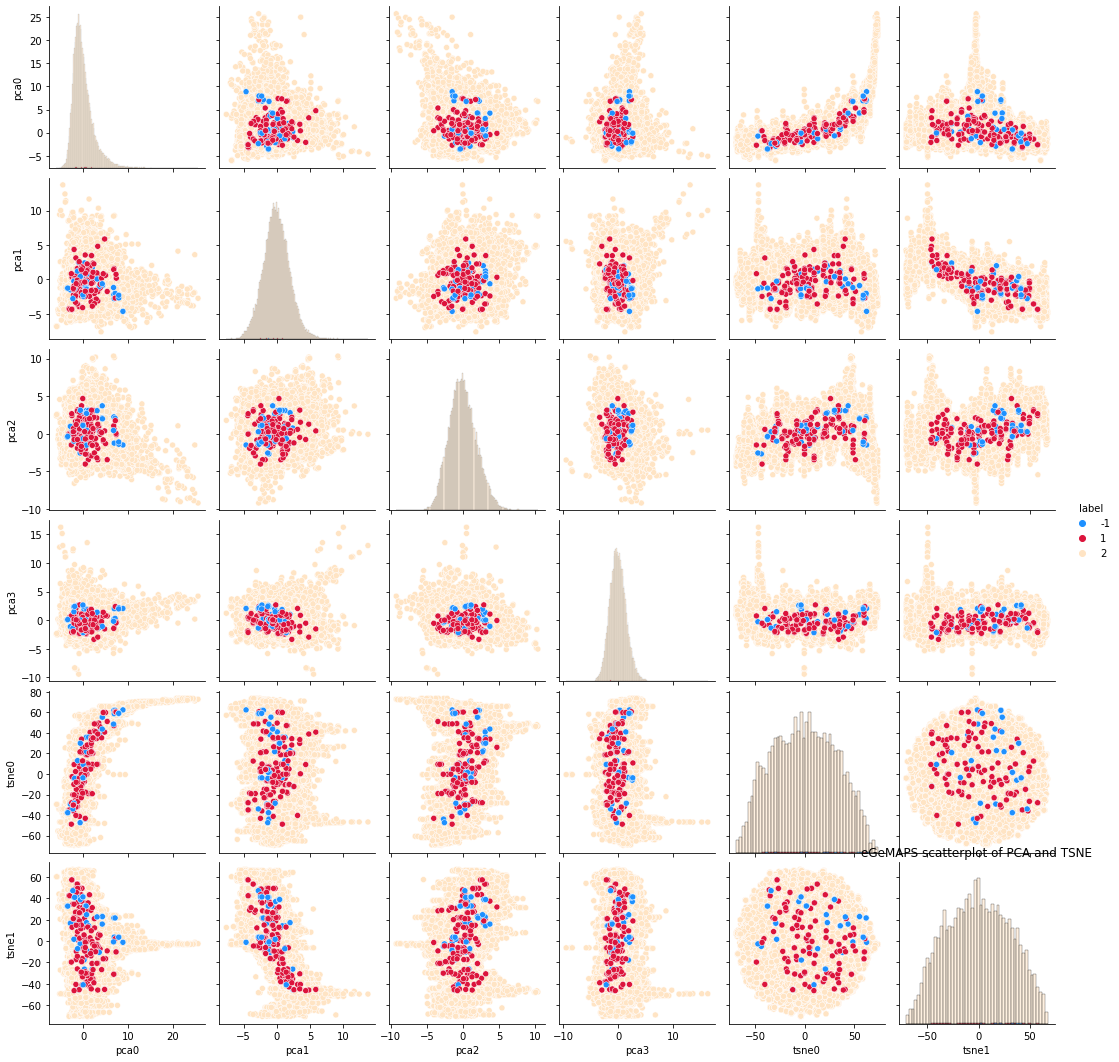

In [49]:
standardised_input = df_std[opensmile_important_features]
pca= PCA(n_components=10, random_state=RANDOM_SEED)
pca_result = pca.fit_transform(standardised_input)
plt.figure(figsize=(10,6))
sns.lineplot(x=np.arange(10),y=pca.explained_variance_ratio_,marker='o',linestyle='--')
plt.grid()
plt.xlabel('Component index')
plt.xticks(np.arange(0, 10, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Component variance')
plt.title('eGeMAPS explained variance by each component')
plt.savefig("pca_opensmile_d.png")
pca_result_split = np.split(pca_result, 10, axis=1)
for component in range(4):
        df_std["pca" + str(component)] = pca_result_split[component]

        
tsne = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, random_state=1)
tsne_result = tsne.fit_transform(standardised_input)
tsne_result_split = np.split(tsne_result, 2, axis=1)
for component in range(2):
        df_std["tsne" + str(component)] = tsne_result_split[component]
sns.pairplot(df_std,vars=["pca0","pca1","pca2","pca3",'tsne0','tsne1'],palette=['dodgerblue','crimson','bisque'],hue='label',kind="scatter",diag_kind="hist")
plt.title('eGeMAPS scatterplot of PCA and TSNE')
plt.savefig("PCATSNE_opensmile.png")


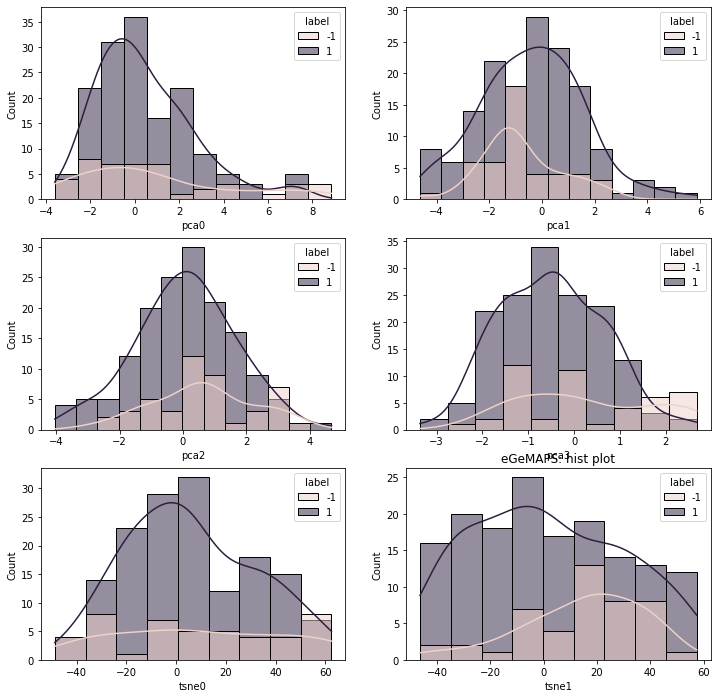

In [50]:
fig, ax_arr = plt.subplots(3,2, figsize=(12,12))

sns.histplot(df_std.iloc[-200:,:],x='pca0',hue='label',kde=True,ax = ax_arr[0][0])
sns.histplot(df_std.iloc[-200:,:],x='pca1',hue='label',kde=True,ax = ax_arr[0][1])
sns.histplot(df_std.iloc[-200:,:],x='pca2',hue='label',kde=True,ax = ax_arr[1][0])
sns.histplot(df_std.iloc[-200:,:],x='pca3',hue='label',kde=True,ax = ax_arr[1][1])
sns.histplot(df_std.iloc[-200:,:],x='tsne0',hue='label',kde=True,ax = ax_arr[2][0])
sns.histplot(df_std.iloc[-200:,:],x='tsne1',hue='label',kde=True,ax = ax_arr[2][1])
plt.title('eGeMAPS: hist plot')
plt.savefig("hist_opensmile.png")


## PCA and TSNE

In [51]:
# Standardise features
df_PCA_TSNE=df_std.iloc[:,-7:]
df_PCA_TSNE.iloc[:,1:]=StandardScaler().fit_transform(df_PCA_TSNE.iloc[:,1:])
#Divide manually labelled data and unlabelled data
labeled_data=df_PCA_TSNE.iloc[-200:,:]
unlabeled_data=df_PCA_TSNE.iloc[:-200, 1:]
#Set random seed
np.random.seed(RANDOM_SEED)
training_indices = list(labeled_data.index[0]+np.random.permutation(199))[:120]
X_train=labeled_data.loc[training_indices,:].iloc[:,-6:]
y_train=labeled_data.label[training_indices]
test_data=labeled_data.loc[[ind for ind in labeled_data.index if ind not in training_indices],:]

In [52]:
baseline_dic=dict()

### Baseline SVC rbf

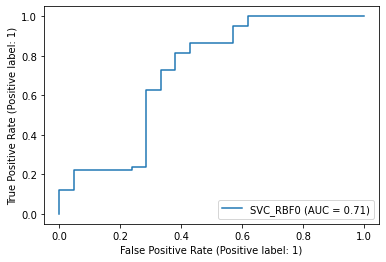

In [53]:
#Initialise the model and tune the parameters 
model=SVC(kernel='rbf',probability=True)
C_range = np.logspace(-1, 5, 6)
gamma_range = np.logspace(-7, 1, 9)
param_grid =dict(gamma=gamma_range, C=C_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,-6:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic['SVC_rbf']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_rbf0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_RBF0')  

### Baseline SVC poly

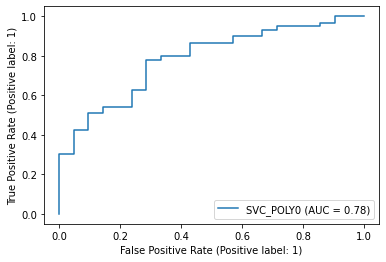

In [55]:
#Initialise the model and tune the parameters 
model=SVC(kernel='poly',probability=True)
coef0_range = np.arange(-15,15,5)
gamma_range = np.logspace(-7, 1, 7)
param_grid =dict(gamma=gamma_range, coef0=coef0_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,-6:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['SVC_poly']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_poly0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_POLY0')  

### Baseline Random Forest

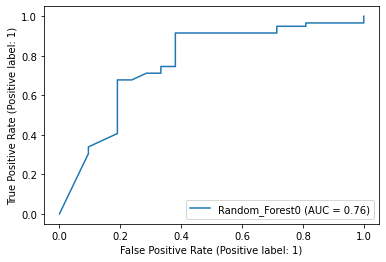

In [56]:
#Initialise the model and tune the parameters 
model=RandomForestClassifier(random_state=RANDOM_SEED)
n_estimators_range = np.arange(10,30,5)
criterion_range = ['gini','entropy']
min_samples_leaf_range=np.arange(2,20,4) 
param_grid=dict(n_estimators=n_estimators_range, criterion=criterion_range,min_samples_leaf=min_samples_leaf_range)
#Evaluate model
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
y_predict=clf.predict(test_data.iloc[:,-6:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['random_forest']=pd.DataFrame(evaluation_dic,index=[0])
rf_disp0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Random_Forest0')  

### Baseline NaiveBayes

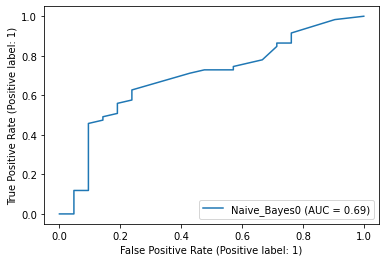

In [57]:
#Initialise the model and tune the parameters 
model = BernoulliNB()
clf=model.fit(X_train,y_train)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,-6:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['Naive_bayes']=pd.DataFrame(evaluation_dic,index=[0])
nb_disp_poly0=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Naive_Bayes0')  

### Generate evaluation table

In [58]:
baseline_df=pd.DataFrame(index=baseline_dic['SVC_rbf'].keys(),columns=baseline_dic.keys())
for i in baseline_df.columns:
    for j in baseline_dic[i]:
        baseline_df.loc[j,i]=baseline_dic[i][j][0]
baseline_df=baseline_df.T
baseline_df

,accuracy,roc_auc,f1,precision,recall
SVC_rbf,0.8,0.711864,0.875,0.78946,0.949153
SVC_poly,0.7625,0.783697,0.861314,0.820353,1.0
random_forest,0.775,0.764326,0.861538,0.75669,0.949153
Naive_bayes,0.75,0.692494,0.852941,0.730519,0.983051


### Over-sampling

In [59]:
# Over-sampling the training set
ros = RandomOverSampler(random_state=RANDOM_SEED)
X_resampled, y_resampled = ros.fit_resample(X_train,y_train)
baseline_dic_balanced=dict()

#### Baseline SVC rbf

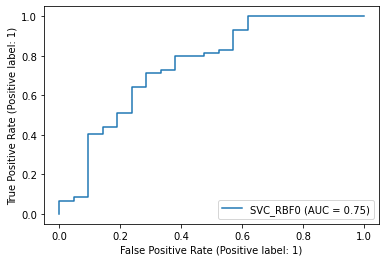

In [60]:
#Initialise the model and tune the parameters 
model=SVC(kernel='rbf',probability=True)
C_range = np.logspace(-1, 5, 6)
gamma_range = np.logspace(-7, 1, 9)
param_grid =dict(gamma=gamma_range, C=C_range)
clf=run_grid_search_cv(X_resampled, y_resampled,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,-6:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic_balanced['SVC_rbf']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_rbf00=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_RBF0')  

#### Baseline SVC poly

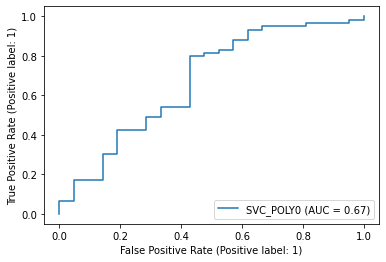

In [61]:
#Initialise the model and tune the parameters 
model=SVC(kernel='poly',probability=True)
coef0_range = np.arange(-15,15,5)
gamma_range = np.logspace(-7, 1, 7)
param_grid =dict(gamma=gamma_range, coef0=coef0_range)
clf=run_grid_search_cv(X_resampled, y_resampled,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,-6:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic_balanced['SVC_poly']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_poly00=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_POLY0')  

#### Baseline Random Forest

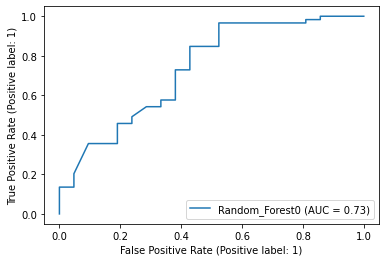

In [62]:
#Initialise the model and tune the parameters 
model=RandomForestClassifier(random_state=RANDOM_SEED)
n_estimators_range = np.arange(10,30,5)
criterion_range = ['gini','entropy']
min_samples_leaf_range=np.arange(2,20,4) 
param_grid=dict(n_estimators=n_estimators_range, criterion=criterion_range,min_samples_leaf=min_samples_leaf_range)
#Evaluate model
clf=run_grid_search_cv(X_resampled, y_resampled,model,param_grid)
y_predict=clf.predict(test_data.iloc[:,-6:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic_balanced['random_forest']=pd.DataFrame(evaluation_dic,index=[0])
rf_disp00=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Random_Forest0')  

#### Baseline NaiveBayes

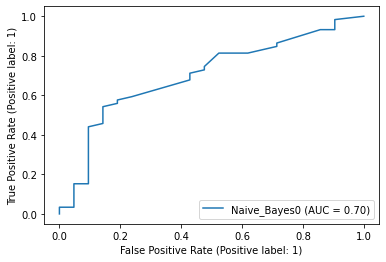

In [63]:
#Initialise the model and tune the parameters 
model = BernoulliNB()
clf=model.fit(X_resampled, y_resampled)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,-6:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic_balanced['Naive_bayes']=pd.DataFrame(evaluation_dic,index=[0])
nb_disp_poly00=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Naive_Bayes0')  

#### Generate evaluation table

In [64]:
baseline_df_balanced=pd.DataFrame(index=baseline_dic_balanced['SVC_rbf'].keys(),columns=baseline_dic_balanced.keys())
for i in baseline_df_balanced.columns:
    for j in baseline_dic[i]:
        baseline_df_balanced.loc[j,i]=baseline_dic_balanced[i][j][0]
baseline_df_balanced=baseline_df_balanced.T
baseline_df_balanced

,accuracy,roc_auc,f1,precision,recall
SVC_rbf,0.825,0.750605,0.893939,0.858562,1.0
SVC_poly,0.725,0.672316,0.816667,0.71676,0.830508
random_forest,0.8375,0.734463,0.897638,0.836949,0.966102
Naive_bayes,0.6375,0.700565,0.707071,0.750312,0.59322


## Raw reduced features

In [65]:
# Standardise features
df_raw_reduced=df_std[opensmile_important_features]
df_raw_reduced.insert(0,'label', df_std.label)
#Divide manually labelled data and unlabelled data
labeled_data=df_raw_reduced.iloc[-200:,:]
unlabeled_data=df_raw_reduced.iloc[:-200, 1:]
#Set random seed
np.random.seed(RANDOM_SEED)
training_indices = list(labeled_data.index[0]+np.random.permutation(199))[:120]
X_train=labeled_data.loc[training_indices,:].iloc[:,1:]
y_train=labeled_data.label[training_indices]
test_data=labeled_data.loc[[ind for ind in labeled_data.index if ind not in training_indices],:]

In [66]:
baseline_dic=dict()

### Baseline SVC rbf

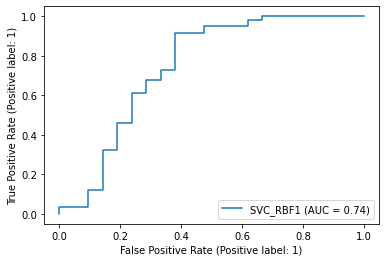

In [67]:
#Initialise the model and tune the parameters 
model=SVC(kernel='rbf',probability=True)
C_range = np.logspace(1, 5, 6)
gamma_range = np.logspace(-7, 1, 9)
param_grid =dict(gamma=gamma_range, C=C_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic['SVC_rbf']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_rbf1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_RBF1')  

### Baseline SVC poly

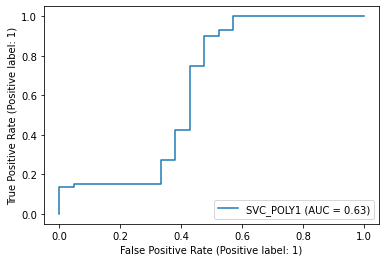

In [68]:
#Initialise the model and tune the parameters 
model=SVC(kernel='poly',probability=True)
coef0_range = np.arange(-15,25,5)
gamma_range = np.logspace(-5, 1, 7)
param_grid =dict(gamma=gamma_range, coef0=coef0_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['SVC_poly']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_poly1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_POLY1')  

### Baseline Random Forest

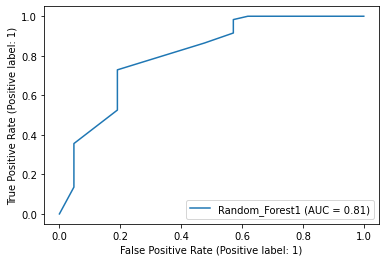

In [69]:
#Initialise the model and tune the parameters 
model=RandomForestClassifier(random_state=RANDOM_SEED)
n_estimators_range = np.arange(25,50,5)
criterion_range = ['gini','entropy']
min_samples_leaf_range=np.arange(1,20,4) 
param_grid=dict(n_estimators=n_estimators_range, criterion=criterion_range,min_samples_leaf=min_samples_leaf_range)
#Evaluate model
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['random_forest']=pd.DataFrame(evaluation_dic,index=[0])
rf_disp1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Random_Forest1')  

### Baseline NaiveBayes

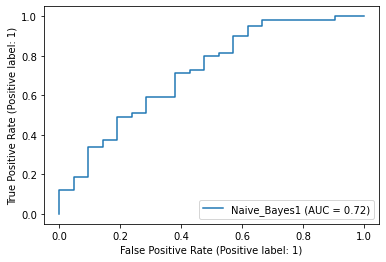

In [70]:
#Initialise the model and tune the parameters 
model = BernoulliNB()
alpha_range=np.arange(2,25,5)
param_grid=dict(alpha=alpha_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[1])
baseline_dic['Naive_bayes']=pd.DataFrame(evaluation_dic,index=[0])
nb_disp_poly1=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Naive_Bayes1')  

### Generate evaluation table

In [71]:
baseline_df=pd.DataFrame(index=baseline_dic['SVC_rbf'].keys(),columns=baseline_dic.keys())
for i in baseline_df.columns:
    for j in baseline_dic[i]:
        baseline_df.loc[j,i]
        baseline_dic[i]
        baseline_df.loc[j,i]=baseline_dic[i][j][0]
baseline_df=baseline_df.T
baseline_df

,accuracy,roc_auc,f1,precision,recall
SVC_rbf,0.8125,0.744956,0.885496,0.823785,0.983051
SVC_poly,0.8125,0.634383,0.88189,0.804228,0.949153
random_forest,0.8375,0.806699,0.899225,0.847321,0.983051
Naive_bayes,0.7875,0.715093,0.866142,0.771507,0.932203


### Over-sampling

In [72]:
# Over-sampling the training set
ros = RandomOverSampler(random_state=RANDOM_SEED)
X_resampled, y_resampled = ros.fit_resample(X_train,y_train)
baseline_dic_balanced=dict()

#### Baseline SVC rbf

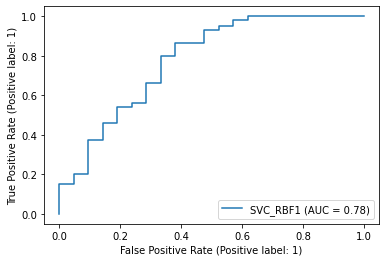

In [73]:
#Initialise the model and tune the parameters 
model=SVC(kernel='rbf',probability=True)
C_range = np.logspace(1, 5, 6)
gamma_range = np.logspace(-7, 1, 9)
param_grid =dict(gamma=gamma_range, C=C_range)
clf=run_grid_search_cv(X_resampled, y_resampled,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic_balanced['SVC_rbf']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_rbf11=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_RBF1')  

#### Baseline SVC poly

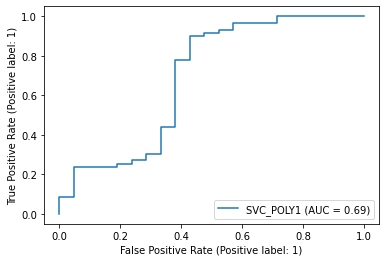

In [74]:
#Initialise the model and tune the parameters 
model=SVC(kernel='poly',probability=True)
coef0_range = np.arange(-15,25,5)
gamma_range = np.logspace(-5, 1, 7)
param_grid =dict(gamma=gamma_range, coef0=coef0_range)
clf=run_grid_search_cv(X_resampled, y_resampled,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic_balanced['SVC_poly']=pd.DataFrame(evaluation_dic,index=[0])
svc_disp_poly11=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='SVC_POLY1')  

#### Baseline Random Forest

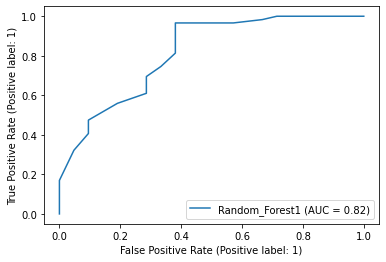

In [75]:
#Initialise the model and tune the parameters 
model=RandomForestClassifier(random_state=RANDOM_SEED)
n_estimators_range = np.arange(25,50,5)
criterion_range = ['gini','entropy']
min_samples_leaf_range=np.arange(1,20,4) 
param_grid=dict(n_estimators=n_estimators_range, criterion=criterion_range,min_samples_leaf=min_samples_leaf_range)
#Evaluate model
clf=run_grid_search_cv(X_resampled, y_resampled,model,param_grid)
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic_balanced['random_forest']=pd.DataFrame(evaluation_dic,index=[0])
rf_disp11=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Random_Forest1')  

#### Baseline NaiveBayes

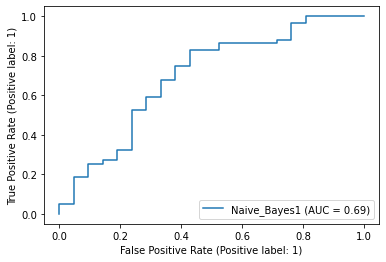

In [76]:
#Initialise the model and tune the parameters 
model = BernoulliNB()
alpha_range=np.arange(2,25,5)
param_grid=dict(alpha=alpha_range)
clf=run_grid_search_cv(X_resampled, y_resampled,model,param_grid)
#Evaluate model
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
baseline_dic_balanced['Naive_bayes']=pd.DataFrame(evaluation_dic,index=[0])
nb_disp_poly11=plot_roc_curve(clf, test_data.iloc[:,1:], test_data.label,name='Naive_Bayes1')  

#### Generate evaluation table

In [77]:
baseline_df_balanced=pd.DataFrame(index=baseline_dic_balanced['SVC_rbf'].keys(),columns=baseline_dic_balanced.keys())
for i in baseline_df_balanced.columns:
    for j in baseline_dic[i]:
        baseline_df_balanced.loc[j,i]=baseline_dic_balanced[i][j][0]
baseline_df_balanced=baseline_df_balanced.T
baseline_df_balanced

,accuracy,roc_auc,f1,precision,recall
SVC_rbf,0.825,0.778047,0.893939,0.858562,1.0
SVC_poly,0.8,0.690073,0.873016,0.787141,0.932203
random_forest,0.85,0.815174,0.904762,0.849541,0.966102
Naive_bayes,0.7125,0.694915,0.79646,0.735737,0.762712


### Plot ROC

#### raw sampling

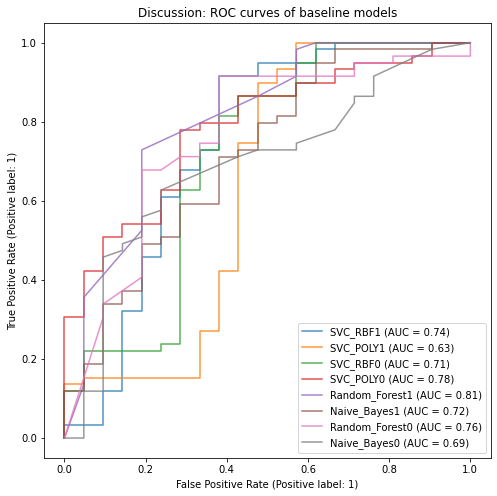

In [78]:
plt.figure(figsize=(8,8))
ax=plt.gca()
svc_disp_rbf1.plot(ax=ax,alpha=0.8)
svc_disp_poly1.plot(ax=ax,alpha=0.8)
svc_disp_rbf0.plot(ax=ax,alpha=0.8)
svc_disp_poly0.plot(ax=ax,alpha=0.8)

rf_disp1.plot(ax=ax,alpha=0.8)
nb_disp_poly1.plot(ax=ax,alpha=0.8)
rf_disp0.plot(ax=ax,alpha=0.8)
nb_disp_poly0.plot(ax=ax,alpha=0.8)

plt.title('Discussion: ROC curves of baseline models')
plt.savefig('ROC_all_d')

#### Over-sampling

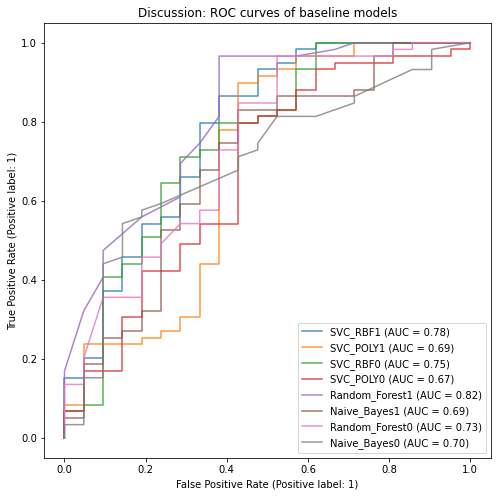

In [79]:
plt.figure(figsize=(8,8))
ax=plt.gca()
svc_disp_rbf11.plot(ax=ax,alpha=0.8)
svc_disp_poly11.plot(ax=ax,alpha=0.8)
svc_disp_rbf00.plot(ax=ax,alpha=0.8)
svc_disp_poly00.plot(ax=ax,alpha=0.8)

rf_disp11.plot(ax=ax,alpha=0.8)
nb_disp_poly11.plot(ax=ax,alpha=0.8)
rf_disp00.plot(ax=ax,alpha=0.8)
nb_disp_poly00.plot(ax=ax,alpha=0.8)

plt.title('Discussion: ROC curves of baseline models')
plt.savefig('ROC_all_d_os')